<a href="https://colab.research.google.com/github/SERVIR/GEDI_Earthhub_ARSET_Training/blob/main/Module_II_Exploring_Forest_Structure_with_GEDI_L2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module II: Exploring Forest Structure with GEDI L2B

run the pip install to to load the needed packages

re-run the cell if/when the restart prompt is given

In [1]:
!pip install earthaccess harmony-py hvplot folium geopandas geoviews

Make a new folder to work in and change directory to that location

In [2]:
!mkdir Module_2_GEDI_L2b

!mkdir Module_2_GEDI_L2b/SPB_AOI
!mkdir Module_2_GEDI_L2b/Prescribed_Burn_AOI
!mkdir Module_2_GEDI_L2b/Sewanee_Domain
!mkdir Module_2_GEDI_L2b/PaintRock_AOI

In [3]:
%cd /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b


https://drive.google.com/drive/folders/1kWSLWgvJs30Cj1wWUBcSIG43I7hX4KeT

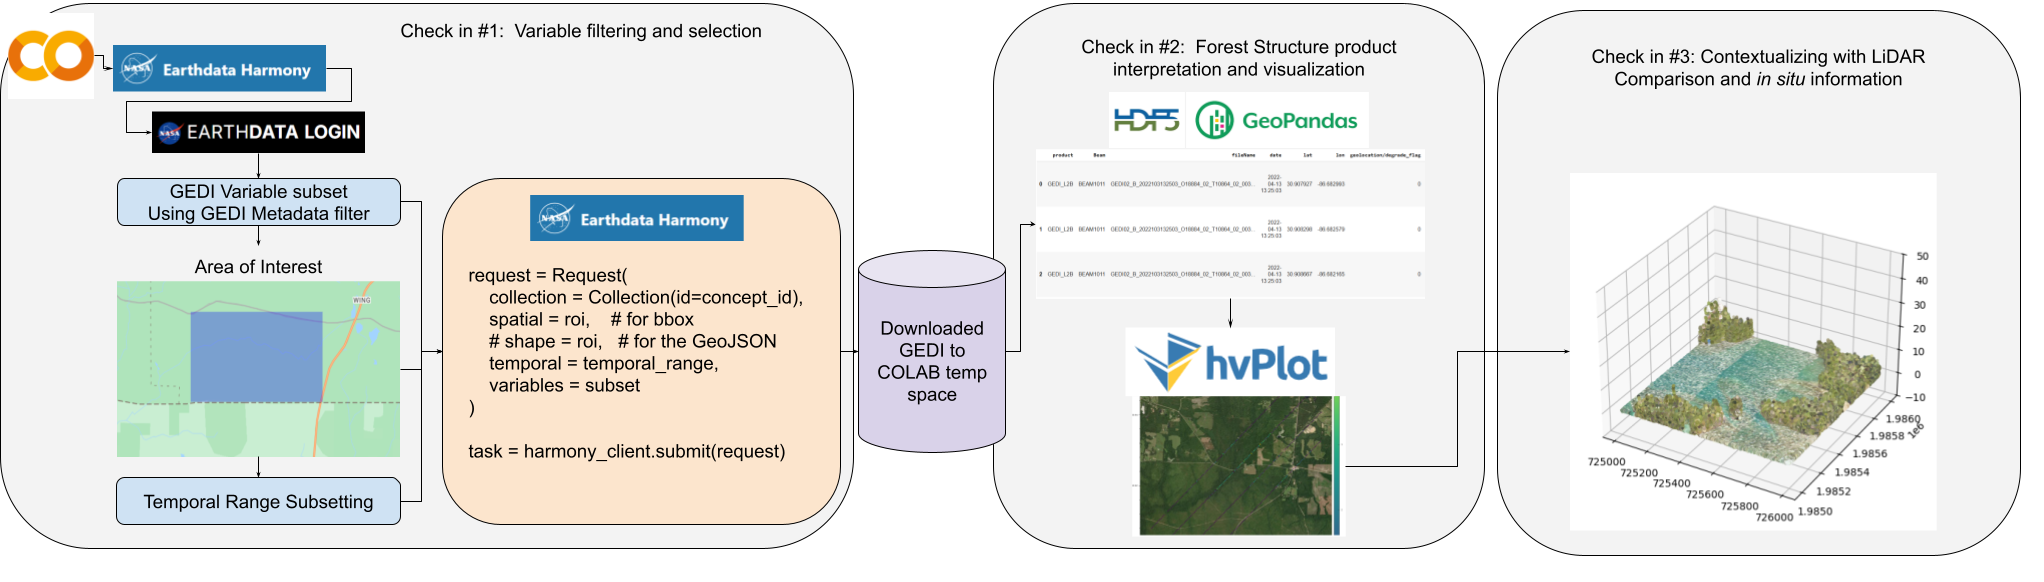

Link to editable workflow (to be removed at the end) https://docs.google.com/drawings/d/1q49Oa-y9W5X25_Qijg0IuSczzcVrcOX5mVfiyIO_UmE/edit

## Authenticate

In [4]:
from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import os
from IPython.display import JSON
import h5py
import pandas as pd
from shapely.geometry import Point
import hvplot.pandas
import folium
from folium import GeoJson
from IPython.display import display, HTML
import requests
from io import StringIO


# gv.extension('bokeh', 'matplotlib')
from holoviews import opts
import shapely
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


os.chdir('../../')

[EarthData Login](https://urs.earthdata.nasa.gov/) If you dont have an account yet. Pause here and set up your arorund and have your username and password ready for this next section

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [5]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [6]:
harmony_client = Client(auth=(auth.username, auth.password))

# Visualize our Areas of intres (AOI)

Add relivant phyphysical and forest informaiton regarind these sites see  the folder here with the docs to support this: https://drive.google.com/drive/folders/1WvBSUIHy6I05j8s1ZZRarho5qnG2wdnb

In [13]:
#bring in aois
geojson_urls = {
    "SPB_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/SPB_AOI.geojson",
    "Prescribed_Burn_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson",
    "Sewanee_Domain": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/Sewanee_Domain.geojson",
    "PaintRockAOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/PaintRockAOI.geojson"
}

In [8]:
# Load GeoJSONs into GeoDataFrames and store map HTML
geojson_gdfs = {}
maps_html = []

def create_map_and_gdf(name, url):
    # Get GeoJSON from URL
    geojson_data = requests.get(url).json()

    # Create GeoDataFrame
    gdf = gp.GeoDataFrame.from_features(geojson_data["features"])
    geojson_gdfs[name] = gdf

    # Determine map center
    coords = geojson_data['features'][0]['geometry']['coordinates']
    geom_type = geojson_data['features'][0]['geometry']['type']

    if geom_type == "Polygon":
        coords = coords[0]
    elif geom_type == "MultiPolygon":
        coords = coords[0][0]
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")

    lat = sum(pt[1] for pt in coords) / len(coords)
    lon = sum(pt[0] for pt in coords) / len(coords)

    # Create map
    fmap = folium.Map(location=[lat, lon], zoom_start=13, tiles="OpenStreetMap")
    folium.GeoJson(geojson_data, name=name).add_to(fmap)

    # Return rendered HTML
    return fmap._repr_html_()

# Generate maps and GeoDataFrames
for name, url in geojson_urls.items():
    html_map = create_map_and_gdf(name, url)
    maps_html.append(html_map)


In [9]:
# Display maps side by side
html = f"""
<div style="display: flex; flex-wrap: wrap;">
    {''.join([f'<div style="flex: 1; min-width: 400px; margin: 5px;">{m}</div>' for m in maps_html])}
</div>
"""
display(HTML(html))

In [10]:
##convert to geopanda dataframes
SPB_AOI = geojson_gdfs["SPB_AOI"]
Prescribed_Burn_AOI = geojson_gdfs["Prescribed_Burn_AOI"]
Sewanee_Domain = geojson_gdfs["Sewanee_Domain"]
PaintRock_AOI = geojson_gdfs["PaintRockAOI"]

In [17]:
minx, miny, maxx, maxy = SPB_AOI.total_bounds
SPB_AOI_roi = (minx, miny, maxx, maxy)

minx, miny, maxx, maxy = Prescribed_Burn_AOI.total_bounds
Prescribed_Burn_AOI_roi = (minx, miny, maxx, maxy)

minx, miny, maxx, maxy = Sewanee_Domain.total_bounds
Sewanee_Domain_roi = (minx, miny, maxx, maxy)


minx, miny, maxx, maxy = PaintRock_AOI.total_bounds
PaintRock_AOI_roi = (minx, miny, maxx, maxy)

(np.float64(-87.41249365706668),
 np.float64(34.14940566292299),
 np.float64(-87.35970778365359),
 np.float64(34.1864759501938))

In [14]:
# # Store all bbox objects in a dictionary for later use
# bbox_dict = {}

# for name, url in geojson_urls.items():
#     gdf = gp.read_file(url)
#     minx, miny, maxx, maxy = gdf.total_bounds
#     bbox = BBox(minx, miny, maxx, maxy)
#     bbox_dict[f"{name}_roi"] = bbox


# # Print all bounding boxes in the desired format
# for var_name, bbox in bbox_dict.items():
#     print(f"{var_name} = BBox({bbox.minx}, {bbox.miny}, {bbox.maxx}, {bbox.maxy})")



# # SPB_AOI_roi = bbox_dict["SPB_AOI_roi"]
# # print(SPB_AOI_roi)
# # Prescribed_Burn_AOI_roi = bbox_dict["Prescribed_Burn_AOI_roi"]
# # print(Prescribed_Burn_AOI_roi)
# # Sewanee_Domain_roi = bbox_dict["Sewanee_Domain_roi"]
# # print(Sewanee_Domain_roi)
# # PaintRockAOI_roi = bbox_dict["PaintRockAOI_roi"]
# # print(PaintRockAOI_roi)
# # Prescribed_Burn_AOI_roi = BBox(-86.68320982, 30.99529573, -86.62706739, 31.02423368)
# # Sewanee_Domain_roi = BBox(-85.98971714751701, 35.127110504508586, -85.85727611112807, 35.235639374867105)
# # PaintRockAOI_roi = BBox(-86.31006140840377, 34.769532701151896, -86.30307836070996, 34.77524552146644)

AttributeError: 'BBox' object has no attribute 'minx'

In [18]:
SPB_AOI_roi = BBox(-87.41249365706668, 34.14940566292299, -87.35970778365359, 34.1864759501938)
Prescribed_Burn_AOI_roi = BBox(-86.68320982, 30.99529573, -86.62706739, 31.02423368)
Sewanee_Domain_AOI_roi = BBox(-85.98971714751701,-85.98971714751701, -85.85727611112807, 35.235639374867105)
PaintRock_AOI_roi = BBox(-86.31006140840377,34.769532701151896, -86.30307836070996, 34.77524552146644)

## Get the GEDI Collections Harmoney Capabilities

Let us start by submitting a capabilities request to see the transformation supported in Harmony API using the GEDI product short names ('GEDI02_A', 'GEDI02_B', 'GEDI01_B'). Besides the `conceptId` and available variables, You can view the supported transformation services. Supported transformation services and variables (such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.) have `True` value. Based on the returned capabilities information for GEDI , we can submit a variable subsetting request, bounding box/shapefile subsetting, and temporal subsetting.

In [19]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

https://lpdaac.usgs.gov/documents/980/gedi_l2b_dictionary_P003_v2.html

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository [(CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [20]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']
print("concept_id:", concept_id)

GEDI02_B , C2142776747-LPCLOUD
concept_id: C2142776747-LPCLOUD


### GEDI Variable Subset

In [21]:
#See the append_field.txt which hasd a long dictionary of the fields and products of GEDI
append_url = "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/append_field.txt"
append_text = requests.get(append_url).text

start_index = append_text.find("{")
end_index = append_text.rfind("}") + 1
dict_str = append_text[start_index:end_index]

append_dict = eval(dict_str)

In [22]:
#Display the dictionary we will use to sort later
append_dict

{'GEDI_L1B': ['geolocation/altitude_instrument',
  'geolocation/local_beam_elevation',
  'tx_sample_start_index',
  'nsemean_odd',
  'ancillary/master_time_epoch',
  'noise_stddev_corrected',
  'tx_pulseflag',
  'geolocation/longitude_bin0_error',
  'selection_stretchers_x',
  'nsemean_even',
  'geolocation/latitude_instrument',
  'geolocation/digital_elevation_model',
  'geolocation/longitude_instrument_error',
  'geolocation/longitude_lastbin_error',
  'tx_egsigma',
  'geolocation/neutat_delay_total_bin0',
  'rx_energy',
  'master_frac',
  'rx_sample_count',
  'rxwaveform',
  'tx_gloc',
  'ancillary/mean_samples',
  'geolocation/longitude_instrument',
  'tx_eggamma_error',
  'rx_offset',
  'tx_egbias_error',
  'geolocation/bounce_time_offset_lastbin',
  'all_samples_sum',
  'geophys_corr/tide_load',
  'geolocation/solar_azimuth',
  'geolocation/mean_sea_surface',
  'geolocation/neutat_delay_total_lastbin',
  'th_left_used',
  'rx_sample_start_index',
  'geophys_corr/tide_ocean',
  'g

In [23]:
######## print only the dictionary fo avaible GEDI 2 B products to explore
gedi_l2b = append_dict.get('GEDI_L2B', {})

# Step 4: Print items under 'GEDI_L2B'
print("Items under 'GEDI_L2B':")
for item in gedi_l2b:
    print(item)

Items under 'GEDI_L2B':
rx_processing/rg_eg_flag_a4
rx_processing/rg_eg_gamma_error_a5
rx_processing/rg_eg_gamma_error_a1
rx_processing/rg_error_a3
rx_processing/rg_eg_amplitude_a2
geolocation/local_beam_elevation
ancillary/rg_eg_constraint_center_buffer
rx_processing/rx_energy_a6
ancillary/tx_noise_stddev_multiplier
pgap_theta_z
rx_processing/rg_eg_center_error_a5
rx_processing/pgap_theta_a4
land_cover_data/modis_nonvegetated
geolocation/longitude_bin0_error
rx_processing/rg_error_a1
geolocation/elev_highestreturn
land_cover_data/landsat_water_persistence
land_cover_data/leaf_on_doy
rx_processing/algorithmrun_flag_a5
geolocation/lon_lowestmode
rx_processing/rx_energy_a4
geolocation/digital_elevation_model
rhov
rx_processing/rg_a5
rx_processing/rg_error_a2
geolocation/longitude_lastbin_error
rx_processing/rg_a6
rx_processing/rg_eg_gamma_a1
l2b_quality_flag
rx_processing/rg_eg_amplitude_error_a4
rx_processing/rg_eg_amplitude_a3
rx_processing/pgap_theta_error_a3
land_cover_data/leaf_off_

Select your variables of intrest

In [24]:
##slim test
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn','l2b_quality_flag','rh100', 'pai', 'fhd_normal']

In [19]:
# subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'lat_highestreturn', 'geolocation/lon_highestreturn', 'geolocation/elev_highestreturn', 'l2b_quality_flag', 'rh100', 'pai', 'pai_z', 'pavd_z','fhd_normal']

In [25]:
### filter those out of the larger list
selected_L2B = []
for s in subset_L2B:
    my_var = [v for v in gedi_l2b if v.endswith(f'{s}')]
    if len(my_var) == 1:
        selected_L2B.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in selected_L2B:
                selected_L2B.append(l)

selected_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'fhd_normal']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [26]:
beams = ['BEAM0101'] # ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']  #['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

In [27]:
# Append our beams of intrest to our variables of intrest
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in selected_L2B]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/fhd_normal']

In [28]:
temporal_range = {'start': datetime(2022, 4, 1),
                  'stop': datetime(2022, 6, 1)}

request = Request(
    collection = Collection(id=concept_id),
    spatial = SPB_AOI_roi,
    temporal = temporal_range,
    variables = subset
)

print("Check if the request payload per aoi:", request.is_valid())

task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/SPB_AOI', overwrite=True)

file_names = [f.result() for f in results]

Check if the request payload per aoi: True
Harmony request ID: adb47adf-6f44-4037-aefc-e5fe67f0914a
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/SPB_AOI/102437068_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5


In [ ]:
# temporal_range = {'start': datetime(2022, 1, 1),
#                   'stop': datetime(2022, 12, 30)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = Prescribed_Burn_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI', overwrite=True)
# results
# file_names = [f.result() for f in results]

In [ ]:
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 12, 1)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = PaintRock_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/PaintRock_AOI', overwrite=True)

# file_names = [f.result() for f in results]

In [ ]:
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 6, 1)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = Sewanee_Domain_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Sewanee_Domain', overwrite=True)

# file_names = [f.result() for f in results]

In [ ]:
# ##One loop

# from datetime import datetime

# # Define temporal range
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 12, 30)}

# # List of spatial objects
# spatial_rois = [
#     SPB_AOI_roi,
#     Prescribed_Burn_AOI_roi,
#     PaintRock_AOI_roi,
#     Sewanee_Domain_AOI_roi
# ]

# # Corresponding output directories
# output_dirs = [
#     '/content/Module_2_GEDI_L2b/SPB_AOI',
#     '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
#     '/content/Module_2_GEDI_L2b/PaintRock_AOI',
#     '/content/Module_2_GEDI_L2b/Sewanee_Domain'
# ]

# # Loop through paired spatial ROIs and directories
# for spatial, out_dir in zip(spatial_rois, output_dirs):
#     print(f"\nSubmitting request for: {out_dir}")

#     request = Request(
#         collection=Collection(id=concept_id),
#         spatial=spatial,
#         temporal=temporal_range,
#         variables=subset
#     )

#     print("Check if the request payload is valid:", request.is_valid())

#     task = harmony_client.submit(request)
#     print(f'Harmony request ID: {task}')

#     print('Processing your Harmony request:')
#     task_json = harmony_client.result_json(task, show_progress=True)

#     results = harmony_client.download_all(task, directory=out_dir, overwrite=True)
#     file_names = [f.result() for f in results]

#     print(f"Download completed for {out_dir}")


In [29]:
## confirm files are in the right spots
!find /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b
/content/Module_2_GEDI_L2b/Sewanee_Domain
/content/Module_2_GEDI_L2b/SPB_AOI
/content/Module_2_GEDI_L2b/SPB_AOI/102437068_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
/content/Module_2_GEDI_L2b/PaintRock_AOI


Function is defined to create a DataFrame from our HDF5 Harmony subset file. Next, `GeoDataFrame` is created for all the downloaded subset file.

In [ ]:
# def h5_to_dataframe(ds, beams, vars):
#     """
#     This function takes Harmony subset of GEDI hdf5 and returns a DataFrame.
#     """
#     import h5py
#     import pandas as pd
#     from datetime import datetime

#     # Read the dataset
#     gedi_ds = h5py.File(ds, 'r')

#     # Extract metadata
#     product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
#     fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
#     date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')

#     # Create an empty DataFrame for this beam
#     df_beam = pd.DataFrame(columns=vars)

#     for b in beams:
#         data_dic = {}
#         for v in vars:
#             try:
#                 value = gedi_ds[f'{b}/{v}'][()]
#                 data_dic[v] = value.tolist()
#             except KeyError:
#                 print(f"Variable {v} not found in {b} of {ds}")
#                 data_dic[v] = []

#         df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)], join="inner")

#         # Add product, beam, file name, and date columns
#         df_beam.insert(0, 'product', product)
#         df_beam.insert(1, 'Beam', b)
#         df_beam.insert(2, 'fileName', fileName)
#         df_beam.insert(3, 'date', date)

#     return df_beam.reset_index(drop=True)


In [ ]:
# import os
# import glob
# import h5py
# import pandas as pd
# import geopandas as gp
# from shapely.geometry import Point
# from datetime import datetime

# # List of directories to search for .h5 files
# output_dirs = [
#     '/content/Module_2_GEDI_L2b/SPB_AOI',
#     '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
#     '/content/Module_2_GEDI_L2b/PaintRock_AOI',
#     '/content/Module_2_GEDI_L2b/Sewanee_Domain'
# ]

# # Define the list of GEDI beams
# beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011',
#          'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

# # Variables (datasets) to extract from each beam
# datasets_p = [
#     'geolocation/lat_lowestmode',
#     'geolocation/lon_lowestmode',
#     'rh100',
#     'quality_flag'
# ]

# # Create an empty DataFrame to store all results
# l2b_df = pd.DataFrame()

# # Loop through each directory and each file inside
# for directory in output_dirs:
#     file_names = glob.glob(os.path.join(directory, '*.h5'))

#     for file in file_names:
#         print(f"Processing file: {file}")
#         try:
#             gedi_subset = h5_to_dataframe(file, beams, datasets_p)
#             l2b_df = pd.concat([l2b_df, gedi_subset], ignore_index=True)
#             del gedi_subset
#         except Exception as e:
#             print(f"Error processing {file}: {e}")

# # Rename lat/lon for clarity
# l2b_df = l2b_df.rename(columns={
#     'geolocation/lat_lowestmode': 'lat',
#     'geolocation/lon_lowestmode': 'lon'
# })

# # Convert to GeoDataFrame with geometry column
# l2b_df = gp.GeoDataFrame(
#     l2b_df,
#     geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1),
#     crs="EPSG:4326"
# )


xxxxxxxxxxxxxxxx

In [30]:
def h5_to_dataframe(ds, beams, vars):
    """
    This function takes Harmony subset of GEDI hdf5 and returns a DataFrame.
    """
    #read the dataset
    gedi_ds = h5py.File(ds,'r')
    # see what is the data product
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    # Create an empty DataFrame for this beam
    df_beam = pd.DataFrame(columns=vars)

    for b in beams:
        data_dic = {}
        for v in vars:
            # print(b,v)
            value = gedi_ds[f'{b}/{v}'][()]
            data_dic[v] = value.tolist()

        df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")

        # add product, beam, file name, and date columns
        df_beam.insert(0, 'product', product)
        df_beam.insert(1, 'Beam', b)
        df_beam.insert(2, 'fileName' , fileName)
        df_beam.insert(3, 'date', date)

    return(df_beam.reset_index(drop=True))


In [31]:
l2b_df = pd.DataFrame()

for file in file_names:
    print(file)
    gedi_subset = h5_to_dataframe(file, beams, selected_L2B)
    l2b_df = gp.GeoDataFrame(pd.concat([l2b_df, gedi_subset]))
    del gedi_subset

# Reset the indeces
l2b_df = l2b_df.reset_index(drop=True)
l2b_df = l2b_df.rename(columns={'geolocation/lat_lowestmode': 'lat', 'geolocation/lon_lowestmode': 'lon'})
# Take the lat/lon from DataFrame and convert each lat/lon to a shapely point and convert to a GeoDataFrame
l2b_df = gp.GeoDataFrame(l2b_df, geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1))


/content/Module_2_GEDI_L2b/SPB_AOI/102437068_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5


/tmp/ipython-input-30-4020160622.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")


In [32]:
l2b_df.head()

,product,Beam,fileName,date,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,fhd_normal,geometry
0,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.186203,-87.381279,0,219.869507,258.868408,258.868408,0,0,-9999.0,-9999.0,POINT (-87.38128 34.1862)
1,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.185847,-87.380829,0,222.295166,258.992218,258.992218,0,0,-9999.0,-9999.0,POINT (-87.38083 34.18585)
2,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.185491,-87.380380,0,222.827911,258.328400,258.328400,0,0,-9999.0,-9999.0,POINT (-87.38038 34.18549)
3,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.185135,-87.379930,0,222.213425,258.507721,258.507721,0,0,-9999.0,-9999.0,POINT (-87.37993 34.18514)
4,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.184795,-87.379498,0,214.657684,227.929138,228.825806,0,88,-9999.0,-9999.0,POINT (-87.3795 34.1848)


In [ ]:
## save as a csv [optional]
# l2b_df.drop(columns='geometry').to_csv("l2b_df.csv", index=False)

In [33]:
l2b_df.hvplot(cmap='viridis', clim=(0,l2b_df['pai'].max()), color='pai', size=10, frame_width=900, geo=True, tiles='ESRI')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (pai)

In [34]:
l2b_df.hvplot(cmap='viridis', clim=(0,l2b_df['fhd_normal'].max()), color='fhd_normal', size=10, frame_width=900, geo=True, tiles='ESRI')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (fhd_normal)

In [35]:
#drop -99999
filtered_gdf = l2b_df[l2b_df['fhd_normal'] != -9999.0]
filtered_gdf
# filtered_gdf = l2b_df[l2b_df['fhd_normal'] >= 1]

,product,Beam,fileName,date,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,fhd_normal,geometry
5,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.184452,-87.379062,0,220.761017,203.309418,232.899658,1,2959,3.997952,3.240268,POINT (-87.37906 34.18445)
6,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.184087,-87.378603,0,223.168640,220.637482,235.021622,1,1438,1.306771,2.576261,POINT (-87.3786 34.18409)
14,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.181268,-87.375037,0,189.371216,174.475403,194.090149,1,1961,2.772222,2.847157,POINT (-87.37504 34.18127)
15,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.180902,-87.374576,0,202.899429,195.876190,220.123764,1,2423,2.279623,3.105921,POINT (-87.37458 34.1809)
16,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.180545,-87.374125,0,202.899429,199.282043,216.804550,1,1752,2.523121,2.655713,POINT (-87.37413 34.18055)
17,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.180189,-87.373675,0,206.864853,201.734482,218.024063,1,1628,3.157755,2.659886,POINT (-87.37368 34.18019)
18,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.179835,-87.373228,0,206.864853,199.462021,221.131653,1,2165,4.999959,2.879517,POINT (-87.37323 34.17984)
19,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.178768,-87.371880,0,207.970688,204.052078,227.776581,1,2371,2.239913,2.831994,POINT (-87.37188 34.17877)
20,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.178412,-87.371431,0,207.970688,205.303116,225.963974,1,2065,3.582412,2.841532,POINT (-87.37143 34.17841)
21,GEDI_L2B,BEAM0101,GEDI02_B_2022123130656_O19194_03_T08589_02_003...,2022-05-03 13:06:56,34.178058,-87.370983,0,210.346008,203.621353,232.128128,1,2850,2.173763,3.287576,POINT (-87.37098 34.17806)


In [36]:
norm = colors.Normalize(vmin=filtered_gdf['fhd_normal'].min(), vmax=filtered_gdf['fhd_normal'].max())
cmap = cm.get_cmap('viridis')  # or 'plasma', 'inferno', etc.

# Create base map centered on the data
m = folium.Map(location=[filtered_gdf['lat'].mean(), filtered_gdf['lon'].mean()], zoom_start=12)

# Add points with color ramp based on RH98
for _, row in filtered_gdf.iterrows():
    rh_value = row['fhd_normal']
    if pd.notnull(rh_value):
        # Convert colormap RGBA to hex
        color = colors.to_hex(cmap(norm(rh_value)))
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
        ).add_to(m)

# Optional: Save and display map
m.save('gedi_interactive_map.html')
m

/tmp/ipython-input-36-374664145.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # or 'plasma', 'inferno', etc.


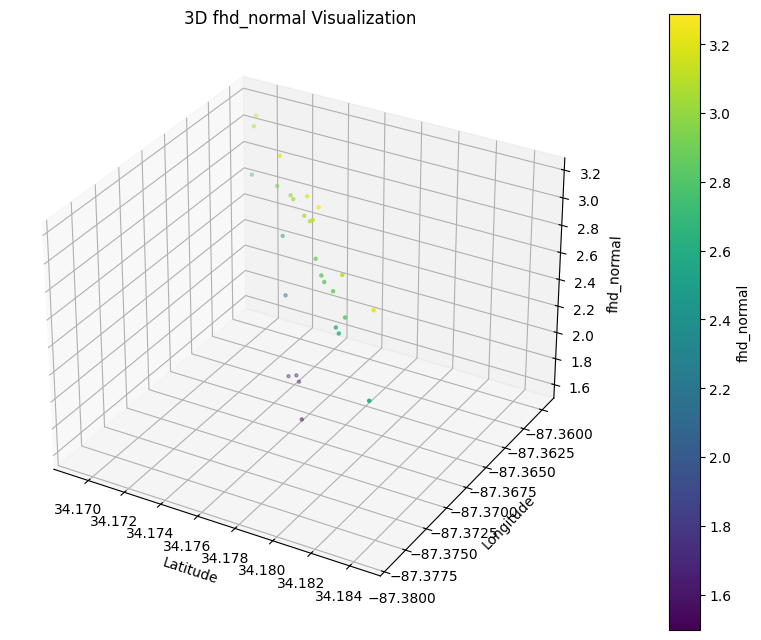

In [37]:
import matplotlib.pyplot as plt

# Required for plots to display properly in Colab
%matplotlib inline
# Drop rows with missing values in relevant columns
df = filtered_gdf.dropna(subset=['lat', 'lon', 'fhd_normal'])

# Extract coordinates
x = df['lat']
y = df['lon']
z = df['fhd_normal']

# Use elevation as rh98_GEDI2A
colors = df['fhd_normal']
color_min = colors.min()
color_max = colors.max()

# Plot the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ensure color scale uses full elevation range
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', s=5, vmin=color_min, vmax=color_max)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('fhd_normal')

# Label axes
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('fhd_normal')

# Set Z axis limits based on data range
ax.set_zlim(color_min, color_max)

plt.title('3D fhd_normal Visualization')
plt.show()

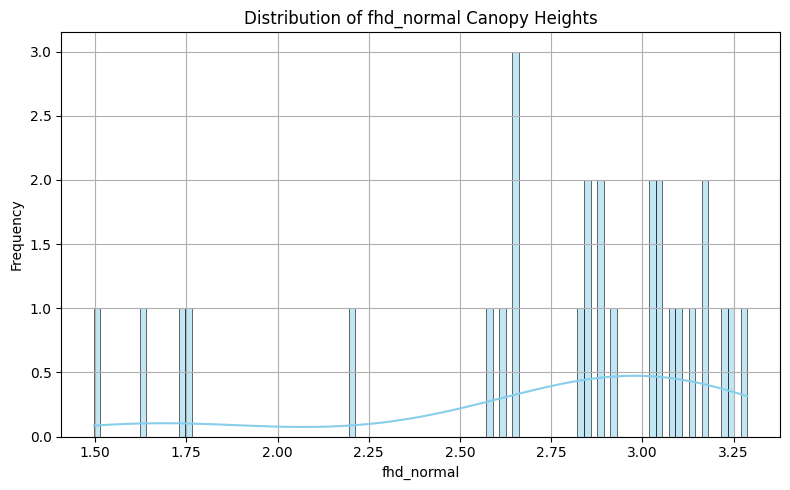

In [38]:
import seaborn as sns
# Create distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(filtered_gdf['fhd_normal'], bins=100, kde=True, color='skyblue')

plt.title('Distribution of fhd_normal Canopy Heights')
plt.xlabel('fhd_normal')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

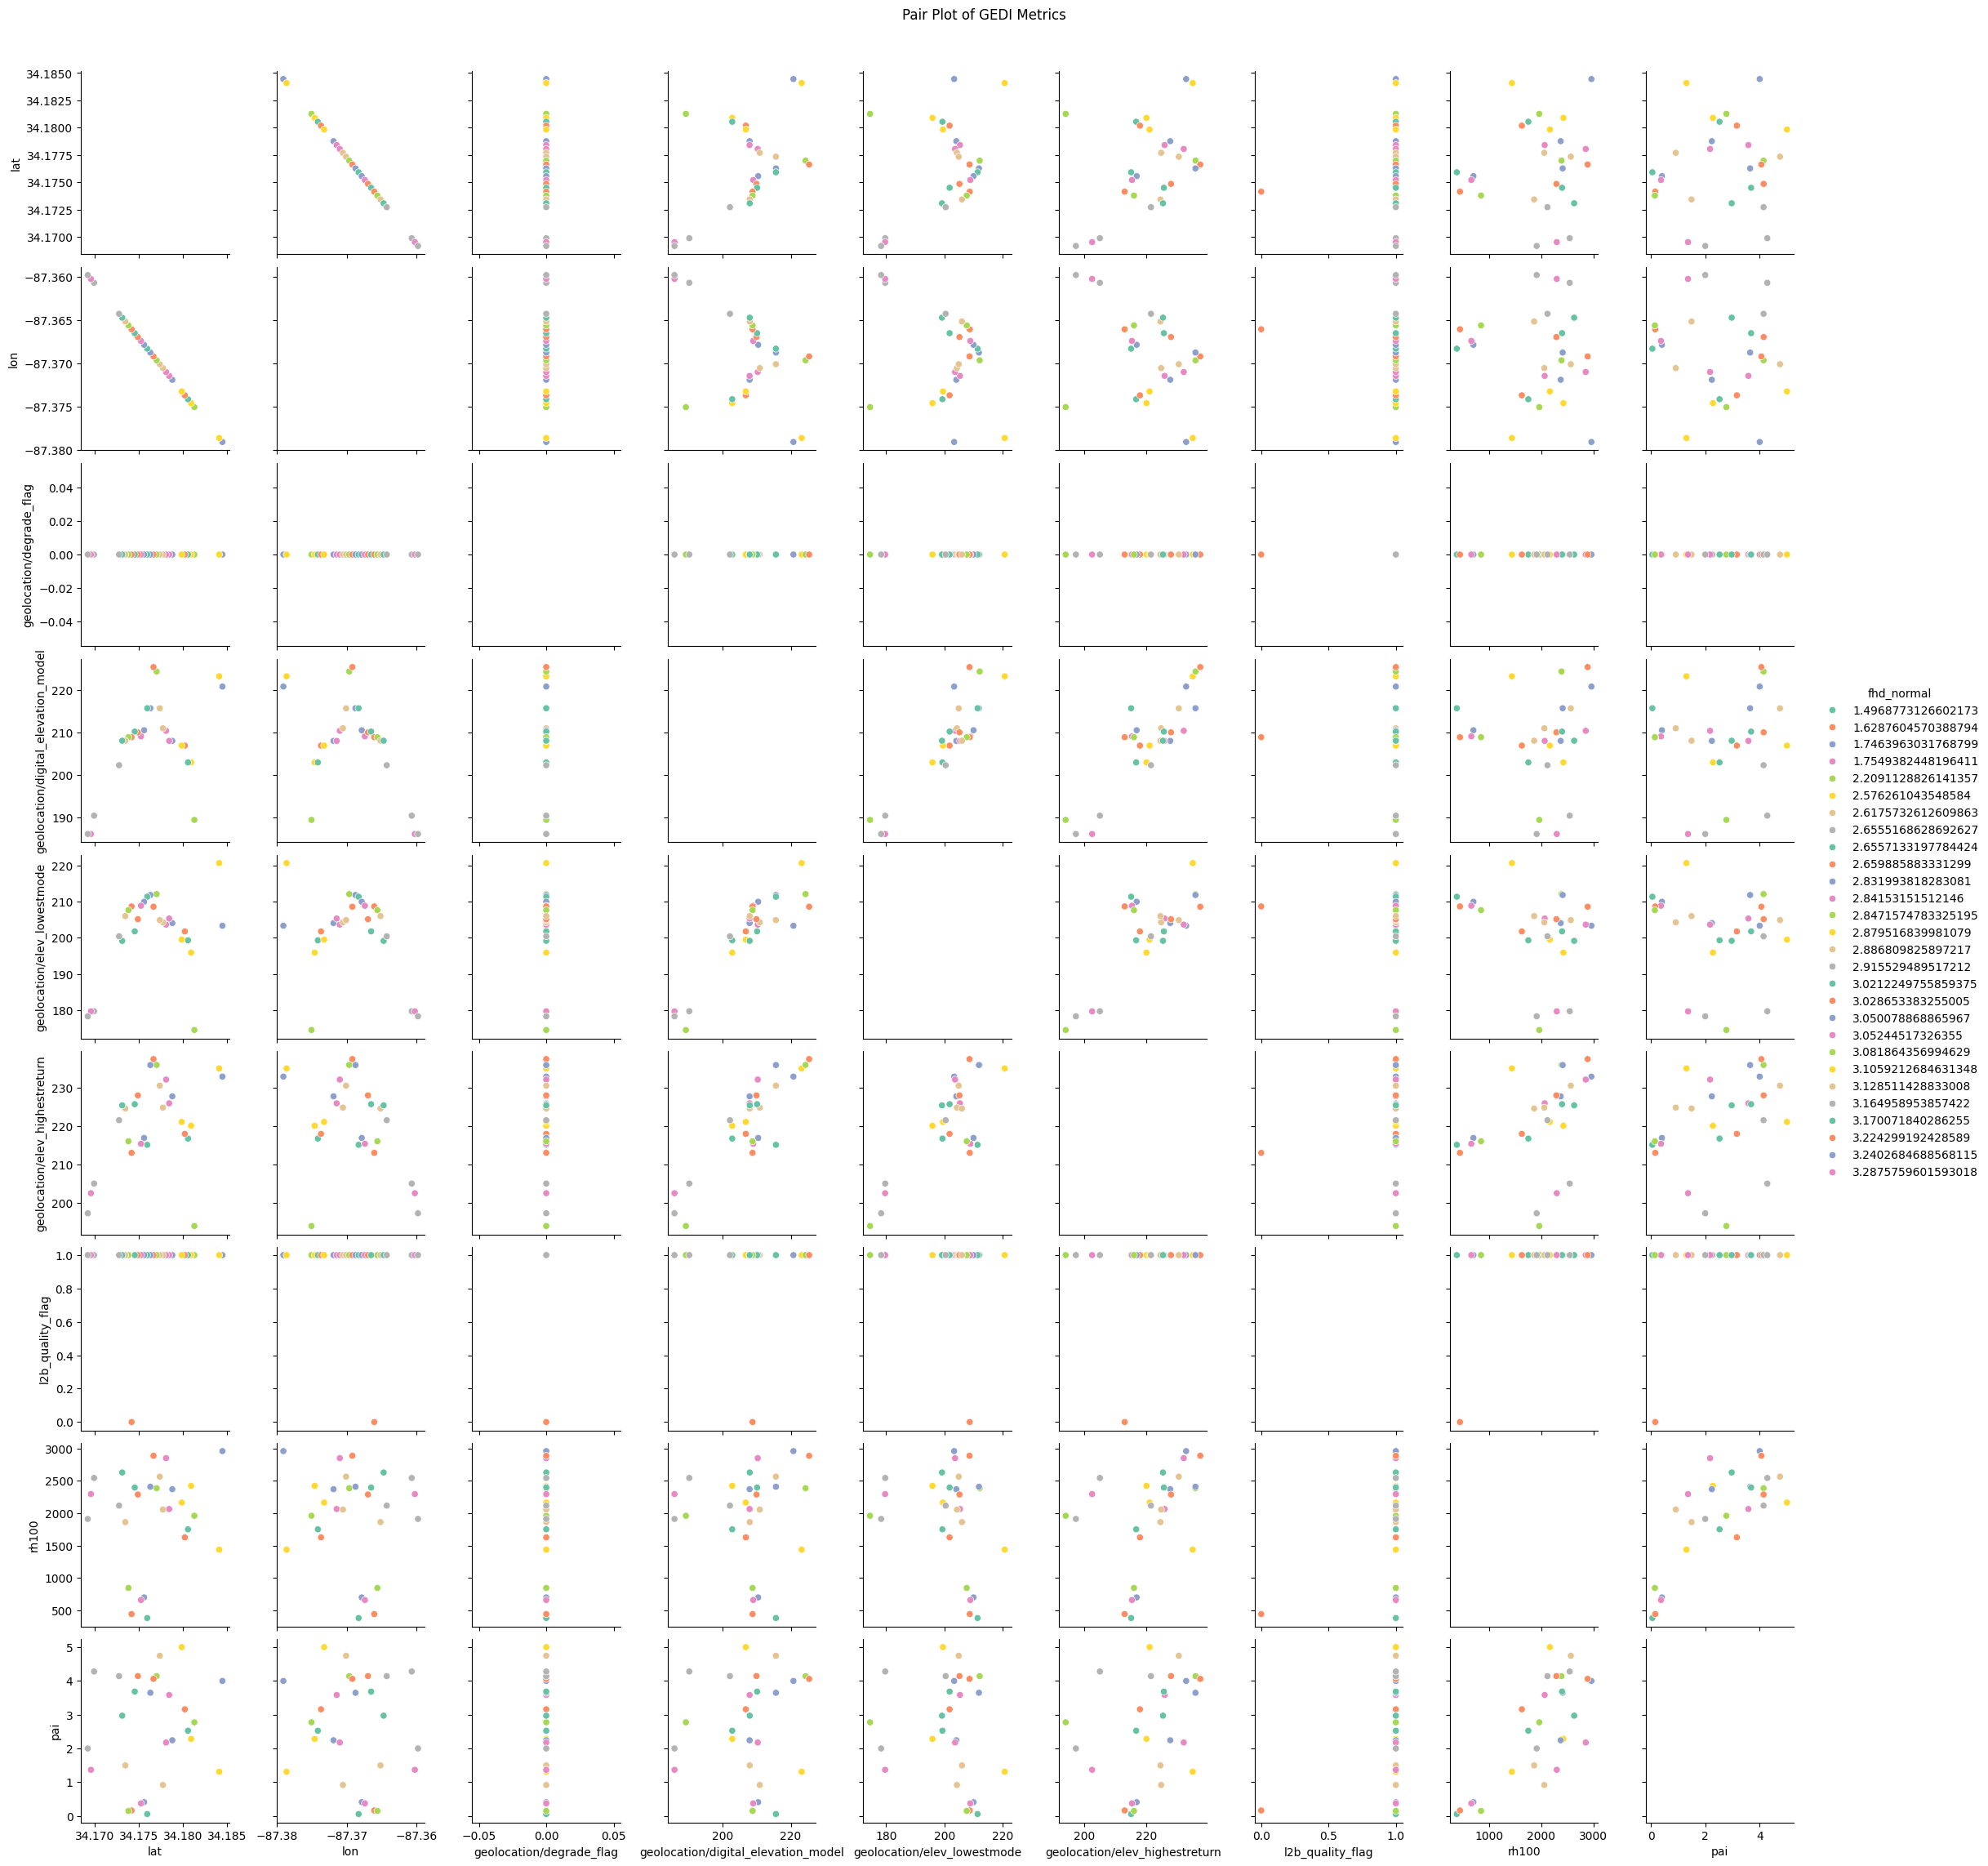

In [39]:
# Create pair plot
sns.pairplot(filtered_gdf, hue="fhd_normal", palette="Set2", diag_kind="kde")
plt.suptitle("Pair Plot of GEDI Metrics", y=1.02)
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
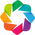

In [42]:
import holoviews as hv
hv.extension('bokeh')

def plot_transect_elevations(filtered_gdf, transect_col='Beam', output_title_prefix='GEDI Beam'):
    """
    Generate elevation transect plots per unique beam in the dataframe.

    Parameters:
    - filtered_gdf: pd.DataFrame or GeoDataFrame with GEDI data.
    - transect_col: str, name of column identifying beam/transect (default: 'Beam')
    - output_title_prefix: str, prefix for plot titles (default: 'GEDI Beam')

    Returns:
    - plots_dict: dict of {beam_name: hv.Overlay} of the combined scatter plots
    """
    plots_dict = {}

    for transect_name, group_df in filtered_gdf.groupby(transect_col):
        group_df = group_df.dropna(subset=[
            'geolocation/digital_elevation_model',
            'geolocation/elev_lowestmode',
            'geolocation/elev_highestreturn'
        ]).copy()

        # Use row index within group for x-axis
        x_vals = range(len(group_df))

        # Create elevation views
        demVis = hv.Scatter((x_vals, group_df['geolocation/digital_elevation_model']),
                            label='DEM (GEDI)').opts(color='black', size=1.5)

        zVis = hv.Scatter((x_vals, group_df['geolocation/elev_lowestmode']),
                          label='Lowest Mode Elevation').opts(color='saddlebrown', size=1.5)

        rhVis = hv.Scatter((x_vals, group_df['geolocation/elev_highestreturn']),
                           label='Canopy Top Elevation').opts(color='darkgreen', size=1.5, tools=['hover'])

        combined = (demVis * zVis * rhVis).opts(
            title=f'{output_title_prefix} {transect_name} Elevation Profile',
            height=500, width=900,
            show_legend=True, legend_position='top_left',
            xlabel='Observation Index', ylabel='Elevation (m)',
            fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16}
        )

        plots_dict[transect_name] = combined

    return plots_dict


In [ ]:

# hv.extension('bokeh')

# def plot_transect_elevations(df, transect_col='beam', output_title_prefix='Transect'):
#     """
#     Generate elevation transect plots per unique transect in the dataframe.

#     Parameters:
#     - df: pd.DataFrame, must contain columns
#           ['Tandem-X DEM', 'SRTM DEM', 'elev_lowest_GEDI2A', 'elev_highest_GEDI2A', transect_col]
#     - transect_col: str, name of column identifying transect/group (default: 'beam')
#     - output_title_prefix: str, prefix for plot titles (default: 'Transect')

#     Returns:
#     - plots_dict: dict of {transect_name: hv.Overlay} of the combined scatter plots
#     """

#     plots_dict = {}

#     for transect_name, group_df in df.groupby(transect_col):
#         # Create Shot Index
#         group_df = group_df.copy()
#         group_df['Shot Index'] = range(len(group_df))

#         # Filter invalid DEM values
#         group_df = group_df[
#             (group_df['Tandem-X DEM'] != -999999.0) &
#             (group_df['SRTM DEM'] != -999999.0)
#         ].dropna(subset=['Tandem-X DEM', 'SRTM DEM', 'elev_lowest_GEDI2A', 'elev_highest_GEDI2A'])

#         # Add renamed columns for plotting
#         group_df['Elevation (m)'] = group_df['elev_lowest_GEDI2A']
#         group_df['Canopy Elevation (m)'] = group_df['elev_highest_GEDI2A']

#         # Create plots
#         demVis = hv.Scatter((group_df['Shot Index'], group_df['Tandem-X DEM']), label='Tandem-X DEM').opts(
#             color='black', size=1.5, height=500, width=900, fontsize={'xlabel': 16, 'ylabel': 16})

#         srtmVis = hv.Scatter((group_df['Shot Index'], group_df['SRTM DEM']), label='SRTM DEM').opts(
#             color='darkblue', size=1.5, height=500, width=900, fontsize={'xlabel': 16, 'ylabel': 16})

#         zVis = hv.Scatter((group_df['Shot Index'], group_df['Elevation (m)']), label='GEDI-derived Elevation').opts(
#             color='saddlebrown', size=1.5, height=500, width=900, fontsize={'xlabel': 16, 'ylabel': 16})

#         rhVis = hv.Scatter((group_df['Shot Index'], group_df['Canopy Elevation (m)']), label='Canopy Top Elevation').opts(
#             color='darkgreen', size=1.5, height=500, width=900, fontsize={'xlabel': 16, 'ylabel': 16},
#             tools=['hover'], xlabel='Shot Index', ylabel='Elevation (m)')

#         combined = (demVis * srtmVis * zVis * rhVis).opts(
#             show_legend=True, legend_position='top_left',
#             fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16},
#             title=f'{output_title_prefix} {transect_name} Elevation Profile'
#         )

#         plots_dict[transect_name] = combined

#     return plots_dict

In [ ]:
# # Assuming final_df is your combined DataFrame with a 'beam' column or other transect ID
# plots = plot_transect_elevations(final_df, transect_col='beam', output_title_prefix='GEDI Beam')

# # To display one transect plot in a Jupyter Notebook:
# plots['BEAM0000']  # replace with your actual transect/beam name

# # To display all transect plots at once:
# hv.Layout(plots.values()).cols(1)

xxxxxxxxxxxxxxxxxxxxxx

In [44]:
# Generate the plots dictionary
plots = plot_transect_elevations(filtered_gdf, transect_col='Beam', output_title_prefix='GEDI Beam')

# Show one beam's transect — change BEAM0101 to any beam you want
plots['BEAM0101']

# Show all transects stacked vertically
hv.Layout(plots.values()).cols(1)


:Layout
   .Overlay.I :Overlay
      .Scatter.DEM_left_parenthesis_GEDI_right_parenthesis :Scatter   [x]   (y)
      .Scatter.Lowest_Mode_Elevation                       :Scatter   [x]   (y)
      .Scatter.Canopy_Top_Elevation                        :Scatter   [x]   (y)

##Contact Info:

Email: timothy.j.mayer@nasa.gov

Organization: SERVIR & Earth Hub

Website: XXXXXXXX

Date last modified: 06-24-2025


Funding for this work was provided through the cooperative agreement 80MSFC22N0004 between NASA and UAH. SERVIR is a joint NASA- and USAID-led program